# SENTIMENT ANALYSIS OF DISTROWATCH REVIEWS.

## Part 3: NLP and unsupervised learning

In part 2 we used the given ratings as labels for classification. We also grouped the ratings to form a set of "positive reviews" and "negative reviews" to convert the multiclass classification problem into a binary classification problem. However, the criteria used for grouping was totally subjective.

In this notebook we try other approaches to group ratings and to create labels in an unsupervised manner

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab_Notebooks/distrowatch NLP

/content/drive/MyDrive/Colab_Notebooks/distrowatch NLP


In [3]:
import re
from pickle import load

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from yellowbrick.target import ClassBalance
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.classifier import ConfusionMatrix,ClassPredictionError
from yellowbrick.cluster import KElbowVisualizer

from nltk import download
# from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
download('stopwords',quiet=True)
from nltk.tokenize import sent_tokenize
download('punkt',quiet=True)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
download('vader_lexicon',quiet=True)

from sklearn.preprocessing import minmax_scale
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression

from scipy.cluster.hierarchy import dendrogram

## Import data

In [4]:
df = pd.read_csv('distrowatch.csv',index_col=0,lineterminator='\n')

## Text processing (see part 2)

In [66]:
def fit_eval(model,corpus_train,corpus_test,ytrain,ytest,k=1):

  """
  Function for assessing model performance
  """

  model.fit(corpus_train,ytrain)
  preds = model.predict(corpus_test)

  global_acc = metrics.accuracy_score(ytest,preds)
  bal_acc = metrics.balanced_accuracy_score(ytest,preds)
  if k > 1:
    probs = model.predict_proba(corpus_test)
    topk = metrics.top_k_accuracy_score(ytest,probs,k=k)
    print(f'Top {k} accuracy:{topk:.3f}')
  print(f'Global accuracy:{global_acc:.3f}')
  print(f'Balanced accuracy:{bal_acc:.3f}')

  confmat = ConfusionMatrix(model,percent=True,is_fitted=True,cmap='Blues')
  confmat.fit(corpus_train,ytrain)
  confmat.score(corpus_test,ytest)
  confmat.show()

  return model

In [6]:
def preproc_tokenize(review):
  text_rating = re.findall(r'\d\/10',review)
  review_modif = re.sub(r'(\b[A-Z]{4,}\b)',r'upperc\1',review)
  review_modif = re.sub(r'\d+\.?','',review_modif)
  tokens = re.findall(r'(?u)\b\w\w+\b|[!|?]',review_modif.lower()) + text_rating
  # stemmed_tokens = [SnowballStemmer('english').stem(w) for w in tokens]
  return tokens

#### stopwords ####

to_keep = ['all','any','both','each','few','most','more','only','too','very'] # not
stop = [w for w in stopwords.words('english') if w not in to_keep]

extra_stop = ['OS','distro','LTS','version','Linux','USB','PC']

# names were obtained from distrowatch.com using web scraping, see notebook for part 1
with open("distro_names", "rb") as f:
  distro_names = load(f)

stop.extend(extra_stop)
stop.extend(distro_names)

# stopwords need to be processed as any other token
stop_tokens = preproc_tokenize(' '.join(stop))

#### Our Bag of Words vectorizer ####

bow_vectorizer = CountVectorizer(
    lowercase=False, # transformation to lowercase is done in preproc_tokenize
    tokenizer=preproc_tokenize, # custom preprocessing and tokenizing function
    stop_words=stop_tokens, # custom set of stop words
    token_pattern=None, # ignore, preproc_tokenize takes care
    ngram_range=(1,2), # unigrams and bigrams
    analyzer='word',
    max_df=0.8,
    min_df=20 # tokens have to appear at least in 20 documents -> this reduces the number of features drastically
)

In [7]:
bow_matrix = bow_vectorizer.fit_transform(df['review'])

## Agglomerative clustering

What if we group categories/ratings based on the similarity of their features? To do that, we can create one "prototype" exemplar for each rating and the apply a hierarchical clustering algorithm to group those representative members of each category. One simple (maybe too simplistic) way to generate a "prototype" for rating/class X is by averaging the value of each of the features for all of the instances with rating X.

In [8]:
bow_dense = bow_matrix.todense()
n_classes = 10
avg_bow = np.zeros((n_classes,bow_dense.shape[1]))
for c in range(n_classes):
  avg_bow[c,:] = bow_dense[df.query(f"rating == {c+1}").index,:].mean(axis=0)

In [9]:
# the similarity measure can be cosine similarity or other
hc = AgglomerativeClustering(n_clusters=2,metric='cosine',linkage='complete',compute_distances=True)
hc.fit(avg_bow)

AgglomerativeClustering(compute_distances=True, linkage='complete',
                        metric='cosine')

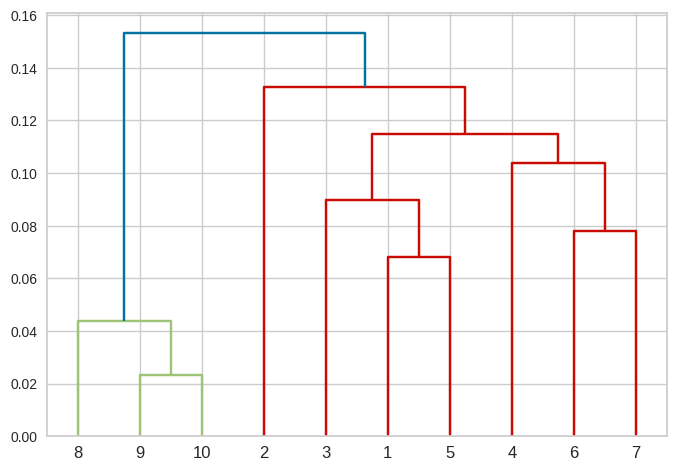

In [10]:
# copied directly from sklearn docs
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plot_dendrogram(hc,color_threshold=0.14,distance_sort='ascending',labels=np.arange(1,11))

Interstingly, whith this solution we arrive at a situation where it is sensible to create two groups, which correspond roughly with positive (ratings 8-10) and negative reviews (ratings 1-7). And I say "roughly" because intuitively one would not consider a rating of 6 or 7 to be negative.

In [11]:
df['rating_hc'] = (df['rating'] >= 8).astype(int)
df['rating_hc'].value_counts(normalize=True)

1    0.760588
0    0.239412
Name: rating_hc, dtype: float64

In [12]:
# to make results comparable to what was found in part 2, we split the data in the same way
# (using original ratings to stratify)
train_ids,test_ids = train_test_split(np.arange(df.shape[0]),
                                      test_size=0.2,stratify=df['rating'],
                                      random_state=66)
corpus_train,ytrain_hc = df.loc[train_ids,'review'],df.loc[train_ids,'rating_hc']
corpus_test,ytest_hc = df.loc[test_ids,'review'],df.loc[test_ids,'rating_hc']

Global accuracy:0.844
Balanced accuracy:0.828


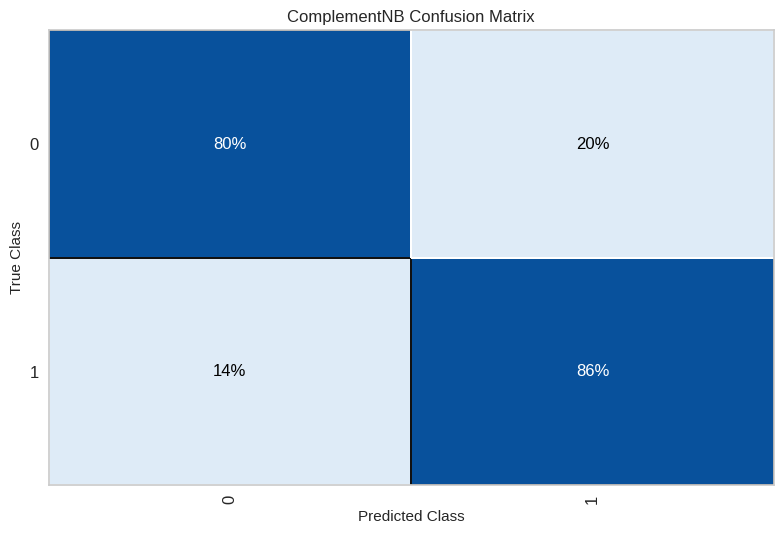

In [13]:
model = Pipeline([
    ('vectorizer',bow_vectorizer),
    ('clf',ComplementNB())
])

fit_eval(model,corpus_train,corpus_test,ytrain_hc,ytest_hc)

## K-means

Up to now we have used the ratings to create the target labels, but what if we ignore this info and generate new labels based on the natural clusters that (we believe) are present in the dataset?

Using K-means we can partition the dataset into a number of predefined groups and use those clusters ids as categories for supervised classification

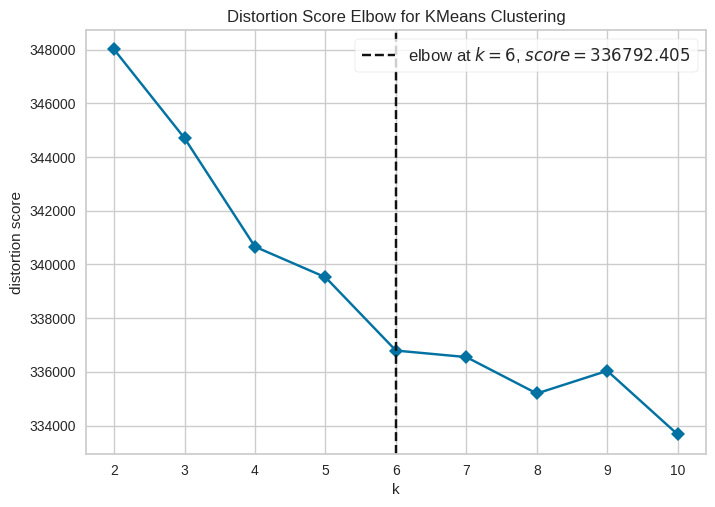

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
# how many clusters?
elbow = KElbowVisualizer(KMeans(n_init='auto'),k=(2,11),timings=False)
elbow.fit(np.array(bow_matrix.todense()))
elbow.show()

It is not clear at all what the optimal number of clusters is (with every run of `KElbowVisualizer` we get different results) so we will assume there are two clusters

In [20]:
km = KMeans(n_clusters=2,n_init='auto',random_state=123)
km.fit(np.array(bow_matrix.todense()))
df['rating_km'] = km.labels_

df['rating_km'].value_counts()

1    3270
0     744
Name: rating_km, dtype: int64

Because we have created an entirely new target variable, I will repeat the process of model selection via cross validation, but this time I will use some novel algorithms like logistic regression and SVM

In [21]:
# transformed data
bow_mat_train = bow_vectorizer.fit_transform(corpus_train)
ytrain_km = df.loc[train_ids,'rating_km']

models = {'Complement NB': ComplementNB(),
          'Logistic regression':LogisticRegression(solver='liblinear'), # default: l2 regularization
          'SVM':SVC(kernel='linear',class_weight='balanced')}

for name,model in models.items():
    cv = cross_val_score(
        model,
        bow_mat_train,
        ytrain_km,
        scoring='balanced_accuracy',
        cv=5,
        n_jobs=-1
    )
    print(name)
    print(f'5-CV balanced accuracy mean:{cv.mean():.3f}')
    print('---')

Complement NB
5-CV balanced accuracy mean:0.638
---
Logistic regression
5-CV balanced accuracy mean:0.876
---
SVM
5-CV balanced accuracy mean:0.956
---


Global accuracy:0.973
Balanced accuracy:0.948


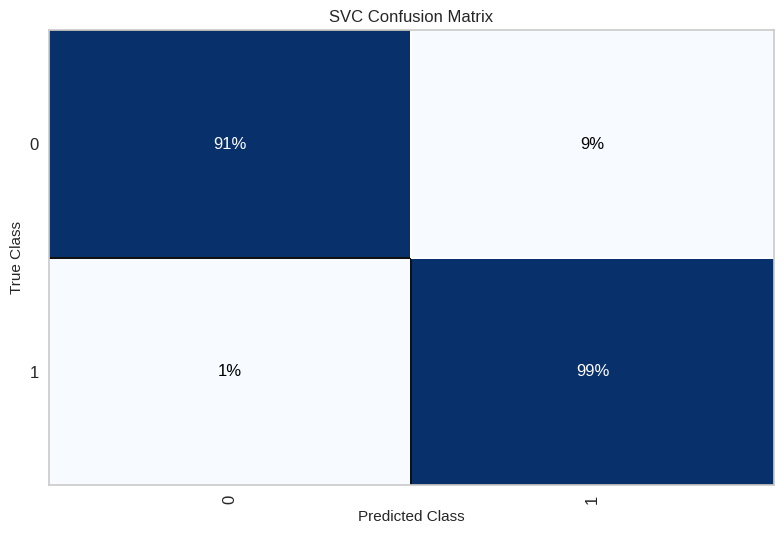

In [78]:
ytest_km = df.loc[test_ids,'rating_km']

model = Pipeline([
    ('vectorizer',CountVectorizer(
        lowercase=False,tokenizer=preproc_tokenize,stop_words=stop_tokens,
        token_pattern=None,ngram_range=(1,2), analyzer='word',max_df=0.8,min_df=20
    )),
    ('clf',SVC(kernel='linear',class_weight='balanced'))
])

model = fit_eval(model,corpus_train,corpus_test,ytrain_km,ytest_km)

Wow! I really didn't expect that level of performance. Now the question is, what do those clusters represent?? Are we really discriminanting between positive and negative reviews (which was our main objective), or are we solving another classification task?

In [79]:
for cl in [0,1]:
  print('CLUSTER',cl)
  for i,row in df.query(f"rating_km == {cl}").sample(5,random_state=919).iterrows():
    display(row['review'])
    print(f"rating:{row['rating']}")
    print('---')

CLUSTER 0


'I am very happy after i installed BOSS 8.0 ... I was shocked that C-DAC made this o.s. very beautifully and customized nicely. I was already have windows from 15 years, but after using BOSS 8.0 , I made my decision to go with BOSS O.S.\rAs i am also using ubuntu & mint from many years....but now i am fully satisfied with good work done by our indian OS.\r Now i am using only our BOSS O.S. as main  O.S. as it completly changed my mind.\r Initially when I  used BOSS 6.0 , then it was good but only driver problem was there.. but after using BOSS 8.0, I am so happy that all problems were removed by cinnamon desktop very easily.. All credits goes to our brillient programmars and indinan C-DAC TEAM. I am giving them very wishes & congratulate them on such a good OS building only for indian peoples\r\rnow BOSS O.S. just behaves & fast like linuxmint.  I will give 10 points but i gave only 9 due to driver wifi incompatiblity with my os ..remaining all are perfect working very nicely...GOOD WO

rating:9
---


"For me who is a long time user of Linux for more than 20 years I have found elementary OS to be a breath of fresh air. I'm in love with the gorgeous desktop pantheon and what excites me the most is the integrated apps like notes and tasks.\r\rThe use of flatpaks is definitely a good move but I would like to see the debian or core Ubuntu apps in the already nice looking app centre.\r\rI am certainly eager to see what version 7.0 will bring to the table but for now this definitely deserves a solid 9.\r\rTo make this distro a perfect 10 it would need the debian and Ubuntu apps ready in there software Centre rather than isolating you to there only hand picked flatpaks (currently about 90), also the pantheon tweak tool should be installed as standard and a selection of themes would be nice as I find myself adding gtk3 themes myself to enhance the pantheon desktop even more.\r\rLibre office needs to be pre installed too and I would like to see a simple gui welcome screen app that gives you 

rating:9
---


'I’ve been using freebsd over the years but always ended back on Linux due to various incompatibility issues (I think the last version I used was 10.x). So thought I would give 13.x a go so I installed in a vm and used for 6 months and got everything set up to match my workflow in Linux with no issues. The current Linux distro I’m using announced they would be going to a container based workflow next year which fits their enterprise model and it is one of the best in my opinion but I tried a beta version and it’s ok but not really aimed at home users anymore so started looking around for a replacement. I build my own pc’s and know what to avoid with Linux so keep things simple and not using anything fancy but it is a ryzen 7, asus board, 64GB memory, 2 ssd’s, and 3 large data drives, no fancy video card, etc. I started going through the freebsd install and noted that it did not pick up the realtek Ethernet port or the wireless which Linux has never failed to pickup, I knew I would have

rating:5
---


'Pros: Where To Start? Kill Switches For VPN, TOR, DNS, Security Score etc! Randomize Your Hardware ID, Set The Timezone To Match VPN Country, Exclude 14 eyes Countries from TOR Circuit, Set TOR Circuit Renewal interval , Set Timers To Wipe RAM, Spoof MAC, Wipe Download and or Documents Folder, Wipe Logs etc In Settings of the dashboard! Canary Warrant, Increased Reliability In IPV6 Isolation, And He Has Fixed Many If Not All Of The Previous Negative reviews Read About It On digi77.com! Dashboard Automatically Saves Settings On Exit! Plus The Great Look And Feel Wonderful Productivity Flow! Fixed The Audio output Device Selection!\r\r Cons: The Dashboard Exits Instead of minimizing To Panel! I Have To Minimize It to the Other Desktop to get it out of the way! Which works since it has an icon in notifications area! it Matters because When It is closed You Do not get the Audible Warnings If Or When There is A problem! The Kill Switches Seem To Still Be Working When It Is Closed But i lik

rating:9
---


'For a long time, I wanted to switch from MX Linux because it ran somewhat slow on my laptop. (My laptop includes a dual-core AMD A6-9225 with Radeon R4 that has a little lower end specs.) So far, I can say that I\'m very pleased with this Linux distribution. I\'m mostly praising Lite for its easy to navigate interface and classic, casual desktop experience with XFCE. I also wanted to switch to an Ubuntu-based distro and though I knew about this distro for a while, I never thought until a few days ago to switch to this after trying others.\r\rPros:\r- Great for new Linux users.\r- Simple and stylish XFCE, the developers seemed to make this as polished as possible\r- Lightweight. I\'m running about 500MB-600MB of RAM on idle.\r- System settings for XFCE seem more expanded since the developers added their own launchers within the setting manager to enchance the experience.\r-Configure everything for your system straight from the welcome screen.\r\rCons:\r- Lots of pre-installed software.

rating:9
---
CLUSTER 1


"Many packages are more up to date than on ArchLinux:\r\r- ruby 3.2.1 on KaOS, 3.0.5  on AL\r- scala 3.2.2 on KaOS, 2.13.8 on AL\r- bash 5.2.015 on KaOS, 5.1.016 on AL\r\rHaving a known (pacman) and not totally custom package manager is a great idea.\r\rKDE (Qt) is the most robust and complete desktop environment and offering only one is a good way to ensure a neat experience. This respect KISS principle.\r\rIt's very simple to use for beginners.\r\rHowever, many second tier packages (in commonness) are not present in KaOS which make it bad for power users:\r\r- groovy\r- crystal\r- vsftpd\r- metalog\r- nuget\r- biber\r\rIt's more a distro for casual users."

rating:7
---


"It's main goal ...hm.. may be gaming? \rAnd it has actually onliny GNOME and KDE versions..\rall other desktop like XFCE4, LXDE, LXQT, not yet available..\rit's pretty resource hungry and not suitable for low spec PC..\rminimal 4 gig ram, etc.\rSo it's brokes main ARCH princips - to be lightweight and minimalistic.\rOf course I like idea to optimize Arch linux for max performance and different compiler optimisations,\rbut as to me - it's already bloated with any kind of software and isn't designed for mini pc, low on resources. I have for example Pentium Silver N6000 with 6W TDP. And I will try standard Arch Linux."

rating:3
---


'Grande Linux is the best distro of all time, as it caters to both beginners and advanced users. I tested several ISOs with a computer with 2GB of RAM and Intel Athon processor, the only one that ran satisfactorily was BIG. I gave life to a stationary switch. BIG revived the love for Linux and free software.\rThis distro is ahead of its time, it has a lot of resources and facilitators, some very old that come from Kurumin Linuz forgotten by the community and others extremely advanced and makes BIG a rocket and an unbreakable system.'

rating:10
---


'Excellent distro, polished, fast and ever works in the right way. Congrats to all Deepin team. I am working with Deepin in my laptop, and everything is going so good. In my opinion is one of the best Linux distro. All the time is growing up. Can´t wait to install Deepin 23, looks like a big step forward. I recommend Deepin to everyone, special for new Linux user. Deepin is so easy to install and set it. Is one of the best option into Debian distros, and one of the best desktop. When you install it you have a fully distro to work for.'

rating:10
---


"Because Arch is the best linux distribution.\rPros:\r+fast.\r+easy to use.\r+like vanilla.\r+powerful package manager.\r+if you like control over operating system Arch is for you.\r+low hardware requirement.\r+completely customizable\r+good documentation.\r+you get a better understanding of how Linux works.\r+rolling release(I like rolling release instead of LTS)\r+Arch Linux is one of the rare few community-only Linux distribution projects.\rCons:\r-not for newbie user.\r-if you don't have much time for configuration stuff not for you.\r"

rating:10
---


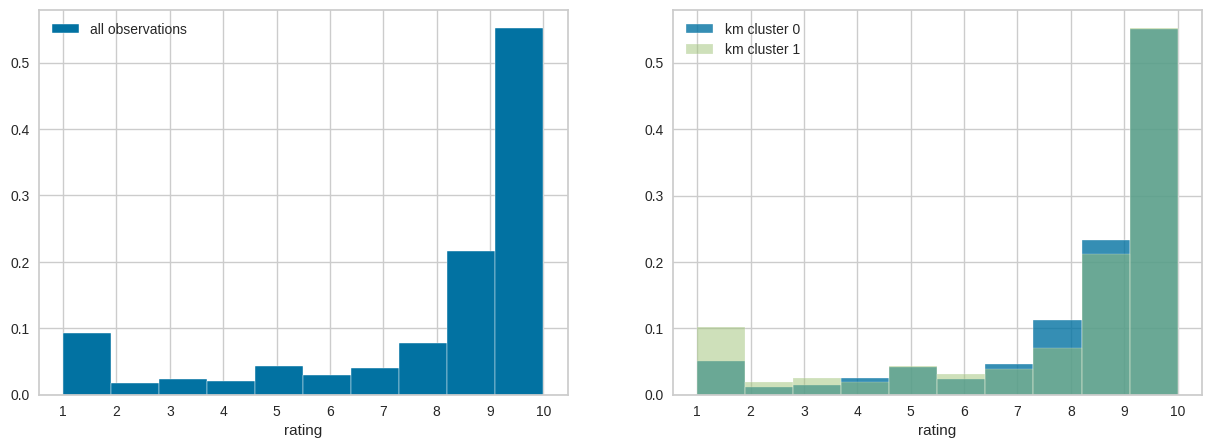

In [80]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=[15,5])

ax[0].hist(df['rating'],density=True,label='all observations',edgecolor='white')

ax[1].hist(df.query("rating_km == 0")['rating'],bins=10,density=True,label='km cluster 0',alpha=0.8,edgecolor='white')
ax[1].hist(df.query("rating_km == 1")['rating'],bins=10,density=True,label='km cluster 1',alpha=0.5,edgecolor='white')

for i in range(2):
  ax[i].set_xlabel('rating')
  ax[i].legend()
  ax[i].set_xticks(np.arange(1,11),labels=np.arange(1,11))

To be honest, after seeing a bunch of examples and inspecting the distribution of ratings I still don't have a clear idea of what the clusters mean. Yes, there is a higher proportion of low ratings (more evident with ratings of 1) in cluster 1 and a higher portion of very good reviews (8 or 9) in cluster 0, but the groups do not seem to be that distinct.

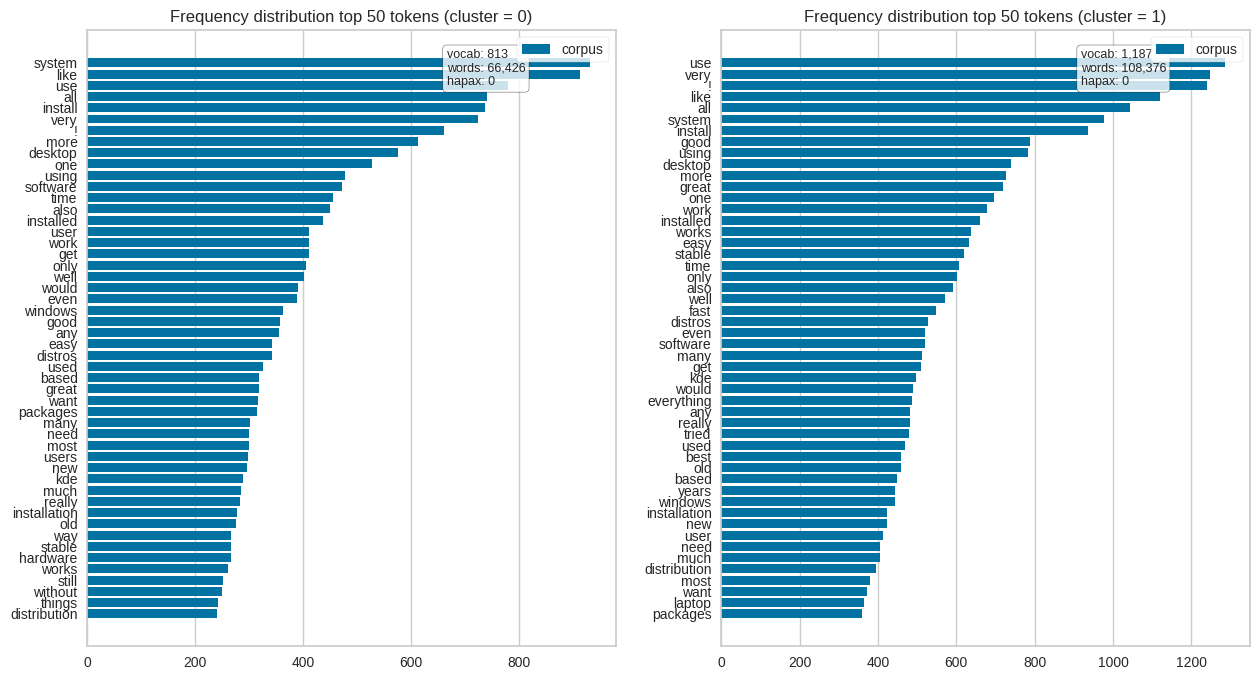

In [70]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=[15,8])
for cl in [0,1]:
  docs = bow_vectorizer.fit_transform(corpus_train[df['rating_km'] == cl])
  features = bow_vectorizer.get_feature_names_out()
  n_tokens = min(50,len(features))
  viz = FreqDistVisualizer(ax=ax[cl],features=features, n=n_tokens,
                           orient='h',
                           title=f'Frequency distribution top {n_tokens} tokens (cluster = {cl})')
  viz.fit(docs)
  viz.finalize()

In terms of frequency of the different tokens, there are no clear differences either

In [81]:
coefs = model['clf'].coef_.todense()
top_tok = np.abs(coefs).argsort()[:,-10:]
coefs[:,top_tok]
model['vectorizer'].get_feature_names_out()[top_tok[0,:]]

array([['also', '!', 'desktop', 'software', 'use', 'very', 'install',
        'like', 'all', 'system']], dtype=object)

## VADER

Finally, we could also rely on external sources to annotate the data. One option is to use the rule-based model [VADER](https://sensorpro.net/ml/vader.pdf) to get the sentiment of the reviews (negative, neutral and positive).

The rules used can be found [here](https://www.nltk.org/_modules/nltk/sentiment/vader.html), with some examples [here](https://www.nltk.org/howto/sentiment.html)

In [82]:
vader = SentimentIntensityAnalyzer()
df['vader_scores'] = df['review'].apply(lambda text: vader.polarity_scores(text)['compound'])

def tag_review(compound_score):
  if compound_score >= 0.5:
    return 'pos'
  elif compound_score <= -0.5:
    return 'neg'
  else:
    return 'neu'

df['vader_sent'] = df['vader_scores'].apply(tag_review)

In [83]:
for i,row in df.query("rating < 7").sample(5,random_state=14).iterrows():
  display(row['review'])
  print(f"rating:{row['rating']}, sentiment:{row['vader_sent']}, score:{row['vader_scores']}".upper())
  print('---')

"User since 2018. After Josh Strobl left the project, things sailed south. The Budgie experience and flagship became hobbled and mostly unusable; an unworkable experience due to upkeep and stack update. For many weeks. The other three offerings are fine.\rIt's unique, one-of-a-kind, visually luxurious operating system. It was a pleasure for a long time. I feel safer with solus than the distro I recently moved to.\rBy the time its woes are sorted out, and the package updates pushed, it likely will have been two months Solus has been almost entirely offline, without updates.\rThat says everything right there.\rIt was already withering with no communication and nervous longtime users, but after this long blackout I can't see any return to the norm.\r"

RATING:6, SENTIMENT:NEU, SCORE:0.1262
---


'\nHad a working install of TrueNAS SCALE (Angelfish).  I upgraded to Bluefin and could no longer login via the web UI.  After multiple attempts at resetting the password I did a full install over my existing.  I set the password via the console and could not login to the web UI.  I then reset the configuration and set the password via the web UI.  After it working just fine after a period of time, I went back to login to the web UI and could no longer log in.  I have had nothing but problems with TrueNAS, I suggest looking for an alternative like openmediavault.'

RATING:1, SENTIMENT:POS, SCORE:0.6527
---


'For server systems only, not good for home computing.'

RATING:1, SENTIMENT:NEU, SCORE:-0.3412
---


"Installed the system, I have a two monitor set up, home build, intel i3 9100f, MSI h310m pro MB, 16g Kingston ram, NVidia gt730 graphics.\r\rUsual KDE issues with two monitors, browser opening to second monitor instead of primary, decided to install Nvidia drivers from the supplied scrip, system searched for correct driver, followed supplied instructions, and rebooted to the terminal only.\r\rI don't mess around with issues like that, too many other distros that actually work, but I have noted my system is not Arch friendly, but I thought I would try again, given Ubuntu Debian distros are so slow compared to a well  tweaked windows 10 OS.\r\rI gave the distro 5, for their effort. Unusable for me. It is what it is !"

RATING:5, SENTIMENT:NEU, SCORE:0.2035
---


'Unfortunately Rescuezilla is still alpha software.\rI created an USB thumbdrive using balenaEtcher. For testing Rescuezilla I used my Acer Aspire3 notebook, which runs quite well under Linux, e.g. with Ubuntu and Slackware.\rRescuezilla booted into a totally black screen with regular graphics settings - but using the failsafe settings (nomodeset, xforcevesa) booted into a usable state.\rI wanted to create an image of an ext4 partition and save that image on my USB HDD. Since the rescuezilla program starts automatically after booting, it should be possible to use that USB drive for storing the image when this drive is plugged in while the rescuezilla app is already running, but it does not get recognized. Thus I had to quit the app and restart it manually.\rI created the image using zstd compression. After that I tested the verify function, but that ended reproducible in a quite strange error message printing a python backtrace.\rI wanted to google that error message, but it was imposs

RATING:2, SENTIMENT:NEU, SCORE:-0.1601
---


In [84]:
df['vader_sent'].value_counts(normalize=True)

pos    0.783757
neu    0.141006
neg    0.075237
Name: vader_sent, dtype: float64

In [ ]:
# for sent,col in zip(['pos','neu','neg'],['#20a39e','#ffba49','#ef5b5b']):
#   plt.hist(df.query(f"vader_sent == '{sent}'")['rating'],density=True,label=sent,
#            alpha=0.8,color=col,edgecolor='white')
#
# plt.legend()
# plt.xticks(np.arange(1,11),labels=np.arange(1,11));

In [85]:
ytrain_vad = df.loc[train_ids,'vader_sent']

models = {'Complement NB': ComplementNB(),
          'Logistic regression':LogisticRegression(solver='liblinear'), # default: l2 regularization
          'SVM':SVC(kernel='linear',class_weight='balanced',decision_function_shape='ovr')}

for name,model in models.items():
    cv = cross_val_score(
        model,
        bow_mat_train,
        ytrain_vad,
        scoring='balanced_accuracy',
        cv=5,
        n_jobs=-1
    )
    print(name)
    print(f'5-CV balanced accuracy mean:{cv.mean():.3f}')
    print('---')

Complement NB
5-CV balanced accuracy mean:0.577
---
Logistic regression
5-CV balanced accuracy mean:0.526
---
SVM
5-CV balanced accuracy mean:0.549
---


Global accuracy:0.755
Balanced accuracy:0.609


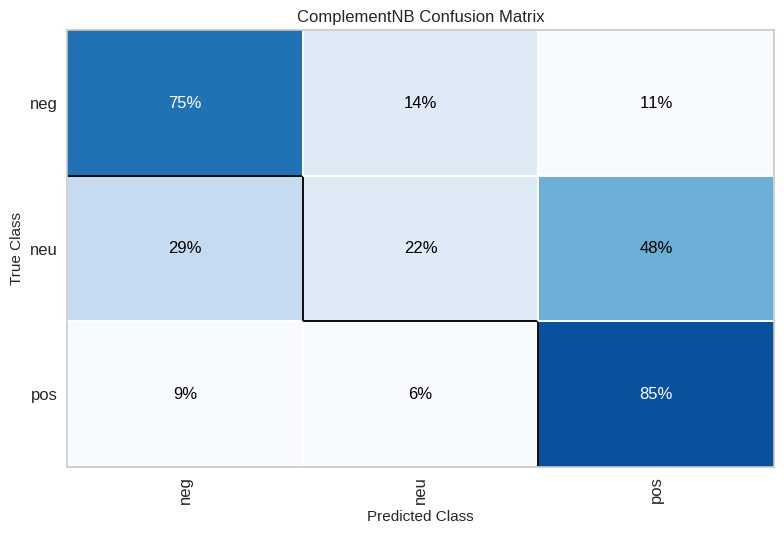

In [87]:
ytest_vad = df.loc[test_ids,'vader_sent']

model = Pipeline([
    ('vectorizer',CountVectorizer(
        lowercase=False,tokenizer=preproc_tokenize,stop_words=stop_tokens,
        token_pattern=None,ngram_range=(1,2), analyzer='word',max_df=0.8,min_df=20
    )),
    ('clf',ComplementNB())
])

model = fit_eval(model,corpus_train,corpus_test,ytrain_vad,ytest_vad)

It seems that the classifier has trouble with neutral reviews. Almost half of them are incorrectly classified as positive and around 30% as negative. The confusion also affects negative reviews because an important 14% of them are identified as neutral. Why can be that?

In a real scenario we would have to tweak our model and preprocessing steps, but here we have access to the real scores given by the users, so we can explore how VADER has worked.

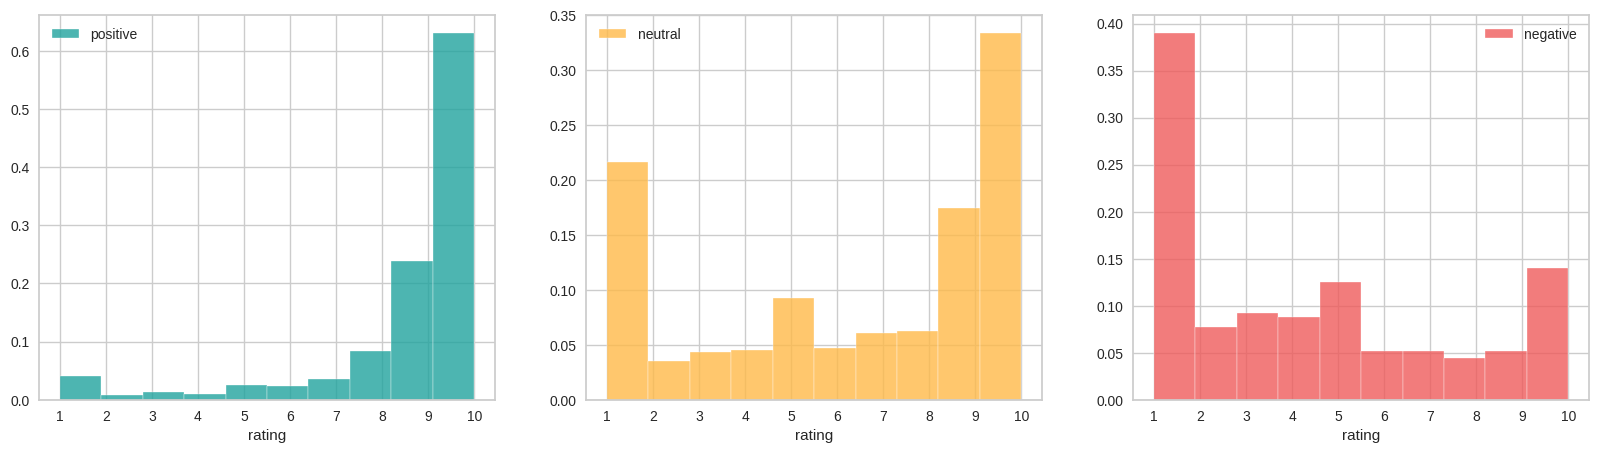

In [88]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=[20,5])

ax[0].hist(df.query("vader_sent == 'pos'")['rating'],density=True,label='positive',alpha=0.8,color='#20a39e',edgecolor='white')
ax[1].hist(df.query("vader_sent == 'neu'")['rating'],density=True,label='neutral',alpha=0.8,color='#ffba49',edgecolor='white')
ax[2].hist(df.query("vader_sent == 'neg'")['rating'],density=True,label='negative',alpha=0.8,color='#ef5b5b',edgecolor='white')

for i in range(3):
  ax[i].set_xlabel('rating')
  ax[i].legend()
  ax[i].set_xticks(np.arange(1,11),labels=np.arange(1,11))

The histograms suggest that part of the confusion is attributable to erroneus labeling of VADER. It does not make sense that such a high proportion of ratings of 10 are considered negative. Nor does it make sense that there are extreme cases (scores of 1 or 10) in the reviews categorized as neutral.

For that reason, in the following section I take a mixed approach where I use VADER but I also take into account the info given by the ratings. Specifically, VADER is going to be applied only to reviews with rating between 3 and 8. The rest are clearly positive or negative so the score will be scaled to be in range [-1,1] and the `tag_review` function will be applied. For VADER ratings, the final sentiment score is not entirely given by VADER itself, it is actually a convex combination of the VADER score and the rating score (scaled):

$sentiment=\text{tag_review}(w\cdot VADER+(1-w)\cdot rating)$

In [ ]:
rating_normalized = minmax_scale(df['rating'],feature_range=(-1,1))

# np.mean([df['vader_scores'],rating_normalized],axis=0)
# df['vader_sent2'] = ( (df['vader_scores'] + rating_normalized) / 2 ).apply(tag_review)
w = 0.2
df['vader_sent2'] = ( w*df['vader_scores'] + (1-w)*rating_normalized).apply(tag_review)

In [107]:
rating_scaled = minmax_scale(df['rating'],feature_range=(-1,1))
doubt = (df['rating'] > 3) & (df['rating'] < 8)
w = 0.4
df['vader_sent2'] = pd.Series(rating_scaled).apply(tag_review)
df.loc[doubt,'vader_sent2'] = ( w*df.loc[doubt,'vader_scores'] + (1-w)*rating_scaled[doubt]).apply(tag_review)

In [109]:
for i,row in df.query("rating < 7").sample(5,random_state=14).iterrows():
  display(row['review'])
  print(f"rating:{row['rating']}, sentiment before:{row['vader_sent']}, sentiment after:{row['vader_sent2']}, score:{row['vader_scores']}".upper())
  print('---')

"User since 2018. After Josh Strobl left the project, things sailed south. The Budgie experience and flagship became hobbled and mostly unusable; an unworkable experience due to upkeep and stack update. For many weeks. The other three offerings are fine.\rIt's unique, one-of-a-kind, visually luxurious operating system. It was a pleasure for a long time. I feel safer with solus than the distro I recently moved to.\rBy the time its woes are sorted out, and the package updates pushed, it likely will have been two months Solus has been almost entirely offline, without updates.\rThat says everything right there.\rIt was already withering with no communication and nervous longtime users, but after this long blackout I can't see any return to the norm.\r"

RATING:6, SENTIMENT BEFORE:NEU, SENTIMENT AFTER:NEU, SCORE:0.1262
---


'\nHad a working install of TrueNAS SCALE (Angelfish).  I upgraded to Bluefin and could no longer login via the web UI.  After multiple attempts at resetting the password I did a full install over my existing.  I set the password via the console and could not login to the web UI.  I then reset the configuration and set the password via the web UI.  After it working just fine after a period of time, I went back to login to the web UI and could no longer log in.  I have had nothing but problems with TrueNAS, I suggest looking for an alternative like openmediavault.'

RATING:1, SENTIMENT BEFORE:POS, SENTIMENT AFTER:NEG, SCORE:0.6527
---


'For server systems only, not good for home computing.'

RATING:1, SENTIMENT BEFORE:NEU, SENTIMENT AFTER:NEG, SCORE:-0.3412
---


"Installed the system, I have a two monitor set up, home build, intel i3 9100f, MSI h310m pro MB, 16g Kingston ram, NVidia gt730 graphics.\r\rUsual KDE issues with two monitors, browser opening to second monitor instead of primary, decided to install Nvidia drivers from the supplied scrip, system searched for correct driver, followed supplied instructions, and rebooted to the terminal only.\r\rI don't mess around with issues like that, too many other distros that actually work, but I have noted my system is not Arch friendly, but I thought I would try again, given Ubuntu Debian distros are so slow compared to a well  tweaked windows 10 OS.\r\rI gave the distro 5, for their effort. Unusable for me. It is what it is !"

RATING:5, SENTIMENT BEFORE:NEU, SENTIMENT AFTER:NEU, SCORE:0.2035
---


'Unfortunately Rescuezilla is still alpha software.\rI created an USB thumbdrive using balenaEtcher. For testing Rescuezilla I used my Acer Aspire3 notebook, which runs quite well under Linux, e.g. with Ubuntu and Slackware.\rRescuezilla booted into a totally black screen with regular graphics settings - but using the failsafe settings (nomodeset, xforcevesa) booted into a usable state.\rI wanted to create an image of an ext4 partition and save that image on my USB HDD. Since the rescuezilla program starts automatically after booting, it should be possible to use that USB drive for storing the image when this drive is plugged in while the rescuezilla app is already running, but it does not get recognized. Thus I had to quit the app and restart it manually.\rI created the image using zstd compression. After that I tested the verify function, but that ended reproducible in a quite strange error message printing a python backtrace.\rI wanted to google that error message, but it was imposs

RATING:2, SENTIMENT BEFORE:NEU, SENTIMENT AFTER:NEG, SCORE:-0.1601
---


In [110]:
(df['vader_sent'] == df['vader_sent2']).value_counts(normalize=True)

True     0.767813
False    0.232187
dtype: float64

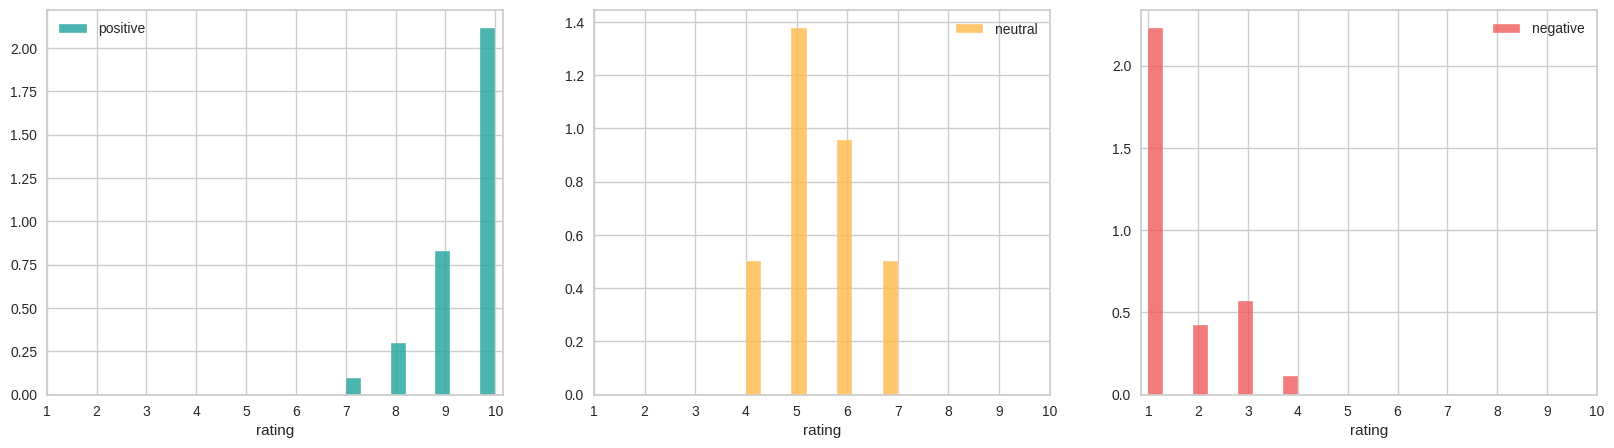

In [111]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=[20,5])

ax[0].hist(df.query("vader_sent2 == 'pos'")['rating'],density=True,label='positive',alpha=0.8,color='#20a39e',edgecolor='white')
ax[1].hist(df.query("vader_sent2 == 'neu'")['rating'],density=True,label='neutral',alpha=0.8,color='#ffba49',edgecolor='white')
ax[2].hist(df.query("vader_sent2 == 'neg'")['rating'],density=True,label='negative',alpha=0.8,color='#ef5b5b',edgecolor='white')

for i in range(3):
  ax[i].set_xlabel('rating')
  ax[i].legend()
  ax[i].set_xticks(np.arange(1,11),labels=np.arange(1,11))

Now the distributions look more like what we would expect

In [112]:
ytrain_vad2 = df.loc[train_ids,'vader_sent2']

models = {'Complement NB': ComplementNB(),
          'Multinomial regression':LogisticRegression(solver='liblinear'), # default: l2 regularization
          'SVM':SVC(kernel='linear',class_weight='balanced',decision_function_shape='ovr')}

for name,model in models.items():
    cv = cross_val_score(
        model,
        bow_mat_train,
        ytrain_vad2,
        scoring='balanced_accuracy',
        cv=5,
        n_jobs=-1
    )
    print(name)
    print(f'5-CV balanced accuracy mean:{cv.mean():.3f}')
    print('---')

Complement NB
5-CV balanced accuracy mean:0.592
---
Multinomial regression
5-CV balanced accuracy mean:0.533
---
SVM
5-CV balanced accuracy mean:0.538
---


Global accuracy:0.808
Balanced accuracy:0.594


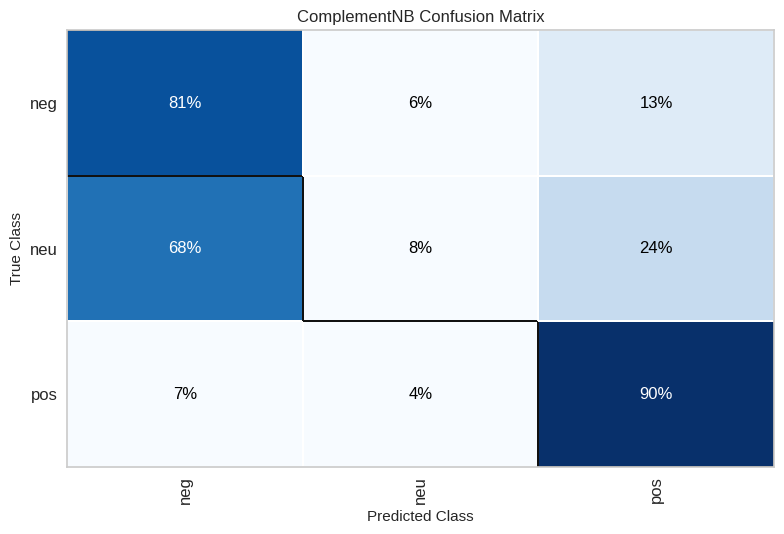

In [113]:
ytest_vad2 = df.loc[test_ids,'vader_sent2']

model = Pipeline([
    ('vectorizer',CountVectorizer(
        lowercase=False,tokenizer=preproc_tokenize,stop_words=stop_tokens,
        token_pattern=None,ngram_range=(1,2), analyzer='word',max_df=0.8,min_df=20
    )),
    ('clf',ComplementNB())
])

model = fit_eval(model,corpus_train,corpus_test,ytrain_vad2,ytest_vad2)

In terms of global accuracy, the model has improved, but the confusion still remains. An unacceptable 68% of what we are considering neutral reviews are classified as negative and 24% as positive reviews. This category is giving a lot of troubles so we should maybe think about going again to the binary situation. This can be achieved just by changing the decision rule of VADER

In [128]:
def binary_tag_review(compound_score):
  if compound_score >= 0:
    return 'pos'
  else:
    return 'neg'

df['vader_sent3'] = df['vader_scores'].apply(binary_tag_review)
df['vader_sent3'].value_counts(normalize=True)

pos    0.873692
neg    0.126308
Name: vader_sent3, dtype: float64

In [129]:
ytrain_vad3 = df.loc[train_ids,'vader_sent3']

models = {'Complement NB': ComplementNB(),
          'Logistic regression':LogisticRegression(solver='liblinear'), # default: l2 regularization
          'SVM':SVC(kernel='linear',class_weight='balanced')}

for name,model in models.items():
    cv = cross_val_score(
        model,
        bow_mat_train,
        ytrain_vad3,
        scoring='balanced_accuracy',
        cv=5,
        n_jobs=-1
    )
    print(name)
    print(f'5-CV balanced accuracy mean:{cv.mean():.3f}')
    print('---')

Complement NB
5-CV balanced accuracy mean:0.740
---
Logistic regression
5-CV balanced accuracy mean:0.675
---
SVM
5-CV balanced accuracy mean:0.690
---


Global accuracy:0.843
Balanced accuracy:0.807


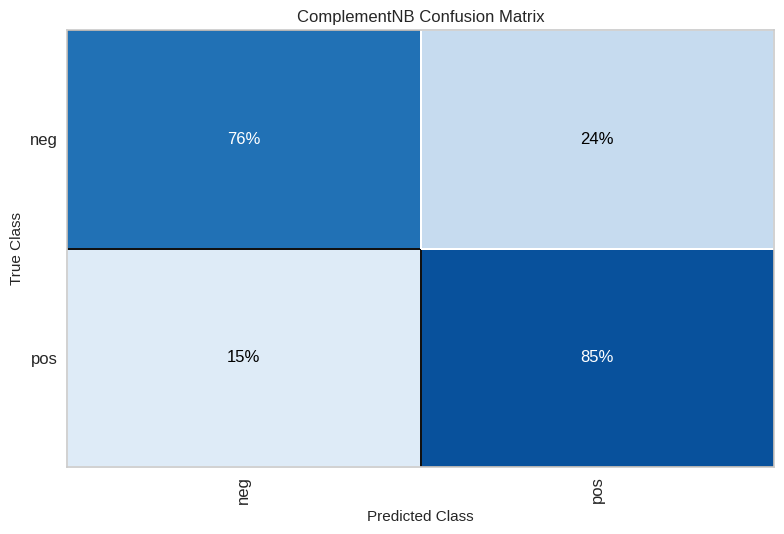

In [130]:
ytest_vad3 = df.loc[test_ids,'vader_sent3']

model = Pipeline([
    ('vectorizer',CountVectorizer(
        lowercase=False,tokenizer=preproc_tokenize,stop_words=stop_tokens,
        token_pattern=None,ngram_range=(1,2), analyzer='word',max_df=0.8,min_df=20
    )),
    ('clf',ComplementNB())
])

model = fit_eval(model,corpus_train,corpus_test,ytrain_vad3,ytest_vad3)

Not bad, and this time we have not needed the original ratings

This concludes part 3. We have seen how to create labels from the data alone and from the data + information about ratings. The results are not impressive but it was worth trying this unsupervised approach